<a href="https://colab.research.google.com/github/satyam-tomar/neural-networks/blob/main/02_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Neural Network — Built From Scratch


I built this project to really *feel* how a neural network works, not just call `.fit()` and move on. Everything here is written using NumPy—weights, activations, loss, backpropagation—the whole journey, manually. Let's begin with data exploration part.


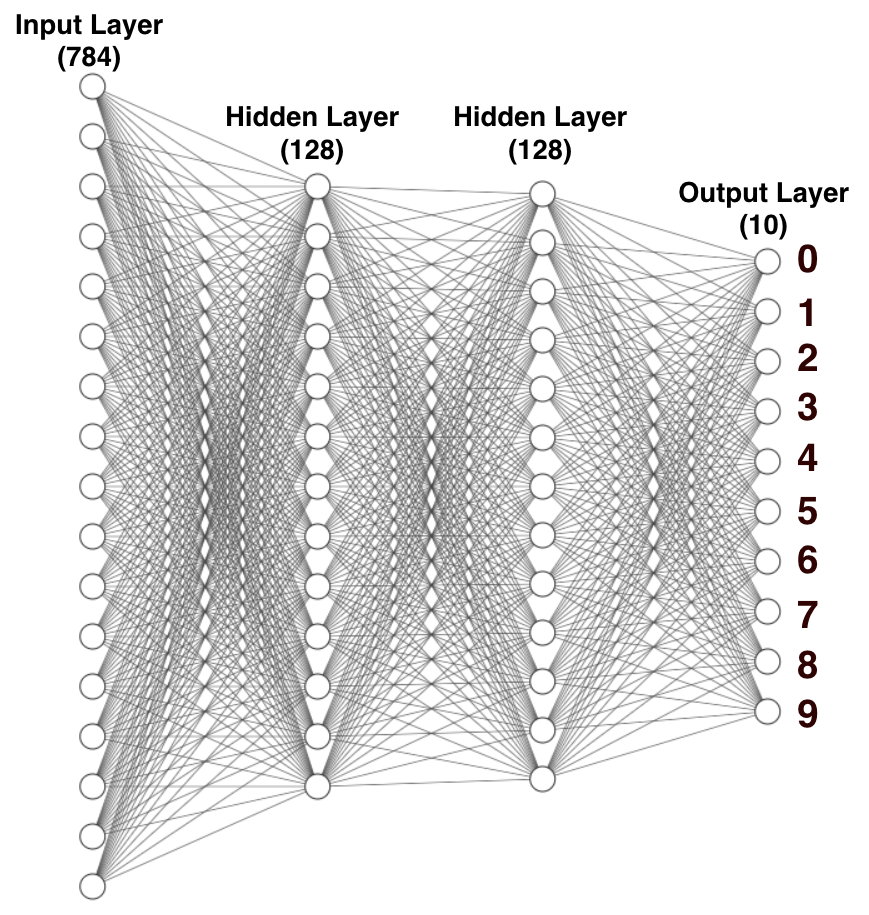

In [18]:
from IPython.display import Image, display

display(Image(filename="neural_network.png"))



## Dataset

MNIST contains 28×28 grayscale images of handwritten digits (0–9).  
Each image is flattened into 784 values and normalized to `[0, 1]` so the network stays numerically calm. Labels are simple integers.
Import dataset as non-frame from openml and plot some 28x28 grayscale images by reshapping them.


In [1]:
!pip install scikit-learn matplotlib

(70000, 784)
(70000,)


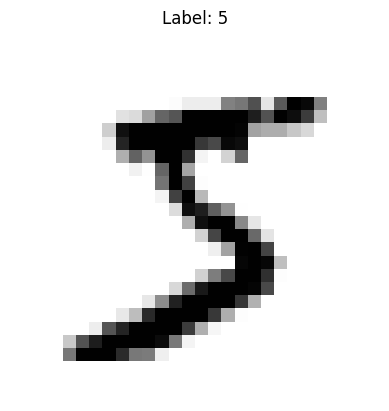

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame=False, parser='auto')

X, y = mnist.data, mnist.target
X = X / 255.0
y = y.astype(np.int64)


print(X.shape)
print(y.shape)

random_digit = X[0].reshape(28, 28)
plt.imshow(random_digit, cmap="binary")
plt.axis("off")
plt.title(f"Label: {y[0]}")
plt.show()

## Model Architecture

A clean, no-nonsense multilayer perceptron:

- Input: 784 features  
- Hidden Layer 1: 128 neurons + ReLU  
- Hidden Layer 2: 64 neurons + ReLU  
- Output Layer: 10 neurons + Softmax  

Nothing fancy, just enough depth to learn meaningful patterns.


In [12]:
import numpy as np

# ---------------- Layers ----------------

class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        # He Initialization: Good for ReLU activations
        self.weights = np.random.randn(n_inputs, n_neurons) * np.sqrt(2. / n_inputs)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values to pass to previous layer
        self.dinputs = np.dot(dvalues, self.weights.T)


class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0


class Activation_Softmax:
    def forward(self, inputs):
        # Subtraction of max value for numerical stability (prevents overflow)
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        self.output = exp_values / np.sum(exp_values, axis=1, keepdims=True)


# ---------------- Loss ----------------

class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        return np.mean(sample_losses)


class Loss_CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        # Clip data to prevent division by 0 or log(0)
        y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Categorical labels (integers)
        if len(y_true.shape) == 1:
            correct_confidences = y_pred[np.arange(samples), y_true]
        # One-hot encoded labels
        else:
            correct_confidences = np.sum(y_pred * y_true, axis=1)

        return -np.log(correct_confidences)

    def backward(self, y_pred, y_true):
        """
        Combined gradient of Softmax and Categorical Cross-Entropy.
        This represents the derivative of the loss with respect to the
        inputs of the softmax function.
        """
        samples = len(y_pred)

        # If labels are integers, convert to one-hot
        if len(y_true.shape) == 1:
            y_true = np.eye(y_pred.shape[1])[y_true]

        # Calculate gradient: (y_pred - y_true) / samples
        self.dinputs = (y_pred - y_true) / samples


# ---------------- Optimizer ----------------

class Optimizer_SGD:
    def __init__(self, learning_rate=0.1):
        self.lr = learning_rate

    def update_params(self, layer):
        layer.weights -= self.lr * layer.dweights
        layer.biases -= self.lr * layer.dbiases


# ---------------- Training Logic ----------------

# 1. Create Mock Dataset (100 samples, 784 features, 10 classes)
# X = np.random.randn(100, 784)
# y = np.random.randint(0, 10, 100)

# 2. Instantiate Network Components
dense1 = Layer_Dense(784, 128)
act1 = Activation_ReLU()
dense2 = Layer_Dense(128, 64)
act2 = Activation_ReLU()
dense3 = Layer_Dense(64, 10)
softmax = Activation_Softmax()

loss_fn = Loss_CategoricalCrossentropy()
optimizer = Optimizer_SGD(learning_rate=0.1)

# 3. The Loop
epochs = 101

for epoch in range(epochs):

    # --- Forward Pass ---
    dense1.forward(X)
    act1.forward(dense1.output)

    dense2.forward(act1.output)
    act2.forward(dense2.output)

    dense3.forward(act2.output)
    softmax.forward(dense3.output)

    # --- Calculate Metrics ---
    loss = loss_fn.calculate(softmax.output, y)
    predictions = np.argmax(softmax.output, axis=1)
    accuracy = np.mean(predictions == y)

    # --- Backward Pass ---
    # Start with the simplified gradient for Softmax + CrossEntropy
    loss_fn.backward(softmax.output, y)

    dense3.backward(loss_fn.dinputs)
    act2.backward(dense3.dinputs)
    dense2.backward(act2.dinputs)
    act1.backward(dense2.dinputs)
    dense1.backward(act1.dinputs)

    # --- Update Weights & Biases ---
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)

    # Print progress
    if epoch % 10 == 0:
        print(f"Epoch {epoch:3}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

print(f"Accuracy: {accuracy*100}")

Epoch   0, Loss: 2.4415, Accuracy: 0.1159
Epoch  10, Loss: 1.6404, Accuracy: 0.5974
Epoch  20, Loss: 1.0698, Accuracy: 0.7471
Epoch  30, Loss: 0.7727, Accuracy: 0.8124
Epoch  40, Loss: 0.6251, Accuracy: 0.8418
Epoch  50, Loss: 0.5418, Accuracy: 0.8593
Epoch  60, Loss: 0.4883, Accuracy: 0.8705
Epoch  70, Loss: 0.4507, Accuracy: 0.8785
Epoch  80, Loss: 0.4226, Accuracy: 0.8849
Epoch  90, Loss: 0.4007, Accuracy: 0.8896
Epoch 100, Loss: 0.3831, Accuracy: 0.8937
Accuracy: 89.37428571428572



## What Happens Inside (One Sample)

Before scaling up, it helps to follow **one sample** slowly.

Example:  
`X = [1.0, 2.0]`, `y = 0`

### Forward Pass

1. `z1 = X · W1 + b1`  
2. `a1 = ReLU(z1)`  
3. `z2 = a1 · W2 + b2`  
4. `y_pred = softmax(z2)`  
5. `loss = -log(y_pred[true_class])`

At this point, the model has made a prediction and knows how wrong it was.

### Backward Pass

1. `dZ2 = y_pred - y_true`  
2. `dW2 = a1ᵀ · dZ2`  
3. `dA1 = dZ2 · W2ᵀ`  
4. `dZ1 = dA1 * ReLU'(z1)`  
5. `dW1 = Xᵀ · dZ1`

Gradients flow backward, blaming each weight for its share of the mistake.

This exact logic repeats for every MNIST image—just faster and in batches.



## Training Logic

The model is trained for multiple epochs using categorical cross-entropy loss and plain SGD.  
After each epoch, loss and accuracy are printed to see whether learning is actually happening (or silently failing).


## Prediction Check

After training, a random MNIST image is passed through the network to see if it can recognize the digit.  
Sometimes it gets it right confidently. Sometimes it humbles me. Both are useful.


## Where This Can Be Better

- Training uses the full dataset at once instead of mini-batches  
- No train/test split (accuracy is optimistic)  
- Optimizer is basic SGD (no momentum or Adam)  
- Single-sample prediction still runs the full dataset  

So yes, it works—and more importantly, it *teaches*.  
With a few upgrades, this can easily turn into a strong, efficient MNIST classifier.

---

*Building this made neural networks feel less like magic and more like math doing its job.*

predicted values: 4


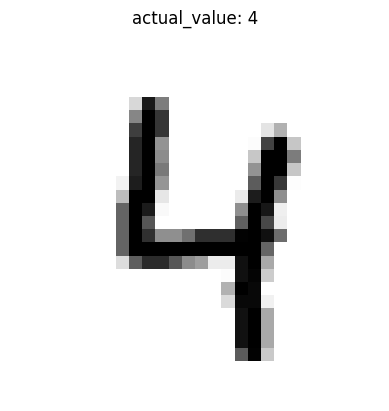

In [25]:
random_index = np.random.randint(0, X.shape[0])
random_number = X[random_index].reshape(28,28)
plt.imshow(random_number,cmap = 'binary' )
plt.axis("off")
plt.title(f"actual_value: {y[random_index]}")

dense1.forward(X)
act1.forward(dense1.output)

dense2.forward(act1.output)
act2.forward(dense2.output)

dense3.forward(act2.output)
softmax.forward(dense3.output)

predictions = np.argmax(softmax.output, axis=1)
print(f"predicted values: {predictions[random_index]}")
